# Compare analyzers on MNIST

This notebook shows how saliency maps are computed for various methods on the MNIST dataset. We will first train a simple 3-layer MLP and then apply different methods. In the end we allow for a qualitive assesment by plotting the analysis as a grid.

Parts of the code that do not contribute to the main focus are outsourced into utility modules. To learn more about the basic usage of **iNNvestigate** have look into this notebook: [Introduction to iNNvestigate](introduction.ipynb)

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter("ignore")

In [2]:
%matplotlib inline

import imp
import os

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as kbackend
import tensorflow.keras.models

tf.compat.v1.disable_eager_execution()

import innvestigate
import innvestigate.utils as iutils

# Use utility libraries to focus on relevant iNNvestigate routines.
import utils as eutils
import utils.mnist as mnistutils

## Data
Load the dataset and keep some images from the test set for the analysis.

In [3]:
# Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(x_train, input_range)

# Preprocess data
data = (
    preprocess(x_train),
    y_train,
    preprocess(x_test),
    y_test,
)

num_classes = len(np.unique(data[1]))
label_to_class_name = [str(i) for i in range(num_classes)]

## Model
The next part trains and evaluates a CNN.

In [5]:
# Create & train model
input_shape = (28, 28,1)

model = keras.models.Sequential(
    [
        keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        keras.layers.Conv2D(64, (3, 3), activation="relu"),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

scores = mnistutils.train_model(model, data, batch_size=128, epochs=10)
print("Scores on test set: loss=%s accuracy=%s" % tuple(scores))

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 34s 562us/sample - loss: 0.1282 - accuracy: 0.9617
Epoch 2/10
60000/60000 [==============================] - 36s 606us/sample - loss: 0.0358 - accuracy: 0.9891
Epoch 3/10
60000/60000 [==============================] - 39s 650us/sample - loss: 0.0197 - accuracy: 0.9937
Epoch 4/10
60000/60000 [==============================] - 40s 665us/sample - loss: 0.0114 - accuracy: 0.9969
Epoch 5/10
60000/60000 [==============================] - 44s 732us/sample - loss: 0.0101 - accuracy: 0.9963
Epoch 6/10
60000/60000 [==============================] - 42s 693us/sample - loss: 0.0089 - accuracy: 0.9971
Epoch 7/10
60000/60000 [==============================] - 41s 681us/sample - loss: 0.0060 - accuracy: 0.9980
Epoch 8/10
60000/60000 [==============================] - 41s 691us/sample - loss: 0.0066 - accuracy: 0.9977
Epoch 9/10
60000/60000 [==============================] - 41s 688us/sample - loss: 0.0045 - accuracy: 0.9

## Analysis

Next, we will set up a list of analysis methods by preparing tuples containing the methods' string identifiers used by `innvestigate.analyzer.create_analyzer(...)`, some optional parameters, a post processing choice for visualizing the computed analysis and a title for the figure to render. Analyzers can be deactivated by simply commenting the corresponding lines, or added by creating a new tuple as below.

For a full list of methods refer to the dictionary `investigate.analyzer.analyzers`

In [6]:
# Scale to [0, 1] range for plotting.
def input_postprocessing(X):
    return revert_preprocessing(X) / 255

noise_scale = (input_range[1] - input_range[0]) * 0.1
ri = input_range[0]  # reference input

# Configure analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN            TITLE
    # Show input
    ("input",               {},                         input_postprocessing,   "Input"),
    # Function
    ("gradient",            {"postprocess": "abs"},     mnistutils.graymap,     "Gradient"),
    ("smoothgrad",
                            {"noise_scale": noise_scale, 
                             "postprocess": "square"},  mnistutils.graymap,     "SmoothGrad"),
    # Signal
    ("deconvnet",           {},                         mnistutils.bk_proj,     "Deconvnet"),
    ("guided_backprop",     {},                         mnistutils.bk_proj,     "Guided Backprop"),
    # Interaction
    ("deep_taylor.bounded", {"low": input_range[0], 
                             "high": input_range[1]},   mnistutils.heatmap,     "DeepTaylor"),
    ("input_t_gradient",    {},                         mnistutils.heatmap,     "Input * Gradient"),
    ("integrated_gradients",{"reference_inputs": ri},   mnistutils.heatmap,     "Integrated Gradients"),
    ("lrp.z",               {},                         mnistutils.heatmap,     "LRP-Z"),
    ("lrp.epsilon",         {"epsilon": 1},             mnistutils.heatmap,     "LRP-Epsilon"),
]

The main loop below will now instantiate the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above.

In [7]:
# Create model without trailing softmax
model_wo_softmax = innvestigate.model_wo_softmax(model)

# Create analyzers.
analyzers = []
for method in methods:
    analyzer = innvestigate.create_analyzer(
        method[0],  # analysis method identifier
        model_wo_softmax,  # model without softmax output
        **method[1]
    )  # optional analysis parameters

    # Some analyzers require training.
    analyzer.fit(data[0], batch_size=256, verbose=1)
    analyzers.append(analyzer)

Now we analyze each image with the different analyzers:

In [8]:
%%capture

n = 10
test_images = list(zip(data[2][:n], data[3][:n]))

analysis = np.zeros([len(test_images), len(analyzers), 28, 28, 3])
text = []


for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]

    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax.predict_on_batch(x)[0]
    prob = model.predict_on_batch(x)[0]
    y_hat = prob.argmax()

    # Save prediction info:
    text.append(
        (
            "%s" % label_to_class_name[y],  # ground truth label
            "%.2f" % presm.max(),  # pre-softmax logits
            "%.2f" % prob.max(),  # probabilistic softmax output
            "%s" % label_to_class_name[y_hat],  # predicted label
        )
    )

    for aidx, analyzer in enumerate(analyzers):
        # Analyze.
        a = analyzer.analyze(x)
        # Apply common postprocessing, e.g., re-ordering the channels for plotting.
        a = mnistutils.postprocess(a)
        # Apply analysis postprocessing, e.g., creating a heatmap.
        a = methods[aidx][2](a)
        # Store the analysis.
        analysis[i, aidx] = a[0]

Next, we visualize the analysis results:

<Figure size 432x288 with 0 Axes>

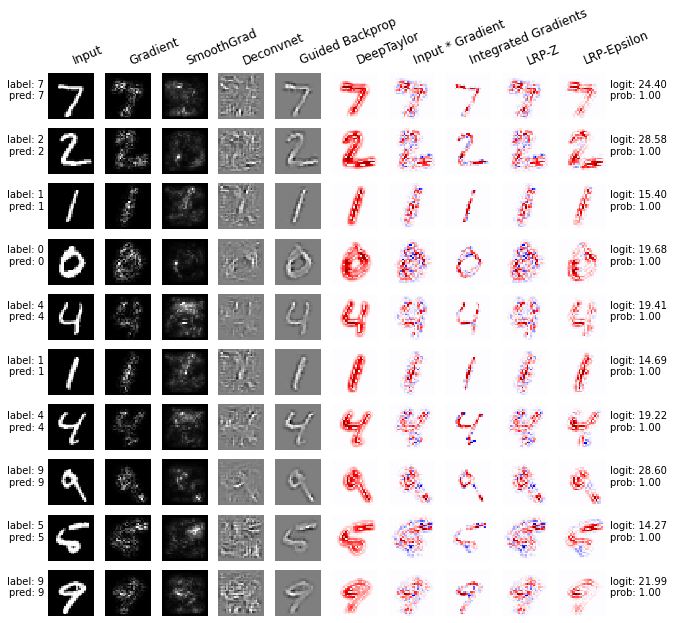

In [9]:
# Prepare the grid as rectengular list
grid = [
    [analysis[i, j] for j in range(analysis.shape[1])] for i in range(analysis.shape[0])
]
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [
    (f"label: {label[i]}", f"pred: {pred[i]}") for i in range(len(label))
]
row_labels_right = [
    (f"logit: {presm[i]}", f"prob: {prob[i]}") for i in range(len(label))
]
col_labels = ["".join(method[3]) for method in methods]

# Plot the analysis.
eutils.plot_image_grid(
    grid,
    row_labels_left,
    row_labels_right,
    col_labels,
    file_name=os.environ.get("PLOTFILENAME", None),
)

Each column shows the visualized results for different analyzers and each row shows the analyses w.r.t. to one input sample. To the left of each row, the ground truth label `label` and the predicted label `pred` are show. To the right, the model's probabilistic (softmax) output is shown as `prob` and the logit output just before the terminating softmax layer as `logit`. Note that all analyses have been performed based on the logit output (layer).

This figure shows the analysis w.r.t. to most activated neuron, e.g., *actually predicted* class. To see how to analyze the prediction w.r.t. to other neurons/classes have a look here: [Analyzing different classes with MNIST](mnist_neuron_selection.ipynb)

If you are curious about how *iNNvestigate* performs on ImageNet model, have a look here: [Comparing methods on ImageNet](imagenet_method_comparison.ipynb) and [Comparing networks on ImageNet](imagenet_network_comparison.ipynb)